# Classical ML Models

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import requests

### Loading data.csv

In [3]:
df = pd.read_csv('../data/csv/data.csv')
display(df.head())
#Randomizing the data
#Selecting the fraction of data to take
sampled_df = df.sample(frac=0.05, random_state=42)
display(sampled_df.head())
sampled_df.count()

,image_url,class
0,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Bacterial_spot
1,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Late_blight
2,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Leaf_Mold
3,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Spider_mites Two-spotted_spider_mite
4,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Late_blight


,image_url,class
1512,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Septoria_leaf_spot
5982,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Leaf_Mold
7106,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Target_Spot
960,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Septoria_leaf_spot
2771,https://raw.githubusercontent.com/spMohanty/Pl...,Tomato___Septoria_leaf_spot


image_url    466
class        466
dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X = sampled_df['image_url']
y = sampled_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
total=len(X_train)+len(X_test)

Training set size: 372
Testing set size: 94


### Performing Image Processing and feature vector generation

In [5]:
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage.feature import local_binary_pattern
from scipy.stats import skew
try:
    from skimage.feature import graycomatrix, graycoprops 
except ImportError:
    from skimage.feature import greycomatrix as graycomatrix  
    from skimage.feature import greycoprops as graycoprops

# ---------- Helper 1: Multi-scale LBP ----------
def extract_lbp_features(gray, radii=[1, 2, 3], P=8):
    lbp_features = []
    for r in radii:
        lbp = local_binary_pattern(gray, P*r, r, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P*r + 3), range=(0, P*r + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.extend(hist)
    return np.array(lbp_features, dtype=np.float32)

# ---------- Helper 2: GLCM (Gray Level Co-occurrence Matrix) ----------
def extract_glcm_features(gray):
    gray_8bit = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    glcm = graycomatrix(gray_8bit, distances=[1, 2, 3],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    feats = [graycoprops(glcm, p).mean() for p in props]
    return np.array(feats, dtype=np.float32)

# ---------- Helper 3: Color Moments ----------
def extract_color_moments(img_rgb):
    chans = cv2.split(img_rgb)
    color_features = []
    for chan in chans:
        color_features.extend([
            np.mean(chan), np.std(chan), skew(chan.flatten(), bias=False)
        ])
    return np.array(color_features, dtype=np.float32)

def get_token():
  with open("../../../../Tokens/github_token.txt", "r") as f:
        token = f.read().strip()
  return token

# ---------- Main Function ----------
def process_image_from_url(url, label,token ,show=False):
    headers = {"Authorization": f"token {token}"}

    try:
        # Step 1: Download
        response = requests.get(url, headers=headers, stream=True, timeout=10)
        response.raise_for_status()
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Failed to decode image: {url}")
            return None, None

        # Step 2: Convert + Resize
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, (256, 256))

        # Step 3: Slight denoise + CLAHE for local contrast
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        img_rgb = cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2RGB)

        # Step 4: Grayscale for texture
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        # --- TEXTURE FEATURES ---
        lbp_feats = extract_lbp_features(gray, radii=[1, 2, 3], P=8)
        glcm_feats = extract_glcm_features(gray)

        # --- COLOR FEATURES ---
        color_moments = extract_color_moments(img_rgb)

        # --- KMEANS COLOR SEGMENTATION ---
        pixels = img_rgb.reshape(-1, 3)
        k = 5
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
        labels = kmeans.fit_predict(pixels)
        cluster_feats = []
        for i in range(k):
            cluster_pixels = pixels[labels == i]
            if len(cluster_pixels) > 0:
                cluster_mean = np.mean(cluster_pixels, axis=0)
                cluster_var = np.var(cluster_pixels, axis=0)
                prop = len(cluster_pixels) / len(pixels)
            else:
                cluster_mean, cluster_var, prop = [0, 0, 0], [0, 0, 0], 0
            cluster_feats.extend([*cluster_mean, *cluster_var, prop])
        cluster_feats = np.array(cluster_feats, dtype=np.float32)

        # Step 5: Merge All Features
        feature_vector = np.concatenate([lbp_feats, glcm_feats, color_moments, cluster_feats])
        feature_vector = feature_vector.astype(np.float32)

        if show:
            segmented_img = kmeans.cluster_centers_[labels].reshape(img_rgb.shape).astype(np.uint8)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(img_rgb)
            axes[0].set_title("Preprocessed Image")
            axes[0].axis('off')
            axes[1].imshow(gray, cmap='gray')
            axes[1].set_title("Grayscale (LBP+GLCM)")
            axes[1].axis('off')
            axes[2].imshow(segmented_img)
            axes[2].set_title("K-Means Color Clusters")
            axes[2].axis('off')
            plt.show()

        # print("Feature vector length:", feature_vector.shape[0])
        return feature_vector, label

    except Exception as e:
        print(f"Error processing {url}: {e}")
        return None, None

token=get_token()
fv_count=0
processed_images_train = []

for url, label in zip(X_train, y_train):
    features, label = process_image_from_url(url,label,token)
    if features is not None:
        processed_images_train.append((features, label))
        fv_count+=1
        print(f"\rImage Count: {fv_count}/{total}",end="",flush=True)

print(f"Number of processed images: {len(processed_images_train)}")


processed_images_test = []

for url, label in zip(X_test, y_test):
    features, label = process_image_from_url(url,label,token)
    if features is not None:
        processed_images_test.append((features, label))
        fv_count+=1
        print(f"\rImage Count: {fv_count}/{total}",end="",flush=True)

print(f"Number of processed images: {len(processed_images_test)}")

# Save processed data to CSV
if processed_images_train:
    train_df = pd.DataFrame([item[0].tolist() for item in processed_images_train])
    train_df['label'] = [item[1] for item in processed_images_train]
    train_df.to_csv(r'../data/csv/processed_images_train.csv', index=False)
    processed_images_train.clear()

if processed_images_test:
    test_df = pd.DataFrame([item[0].tolist() for item in processed_images_test])
    test_df['label'] = [item[1] for item in processed_images_test]
    test_df.to_csv(r'../data/csv/processed_images_test.csv', index=False)
    processed_images_test.clear()
print("Processed data saved to processed_images_train.csv and processed_images_test.csv")

Image Count: 1/466

KeyboardInterrupt: 

In [22]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('../data/csv/processed_images_train.csv')
test_df = pd.read_csv('../data/csv/processed_images_test.csv')

# Convert DataFrame rows to list of tuples
# Assumes the CSV has columns: 'feature_vector', 'label'
def df_to_list_of_arrays(df):
    processed_list = []
    X = df.iloc[:, :-1].values.astype(np.float32)
    y = df.iloc[:, -1].values
    processed_list = [(f, l) for f, l in zip(X, y)]
    return processed_list

processed_images_train = df_to_list_of_arrays(train_df)
processed_images_test = df_to_list_of_arrays(test_df)

print("Data read from CSV and converted back to list format.")
print(f"Number of items in processed_images_train: {len(processed_images_train)}")
print(f"Number of items in processed_images_test: {len(processed_images_test)}")


Data read from CSV and converted back to list format.
Number of items in processed_images_train: 3729
Number of items in processed_images_test: 933



📊 Model Performance Summary:


,Accuracy
SVM,0.851018
Random Forest,0.744909
KNN,0.622722
Decision Tree,0.589496
Naive Bayes,0.408360


C:\Users\user\AppData\Local\Temp\ipykernel_88736\2861131815.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_df.index, y=acc_df['Accuracy'], palette="mako")


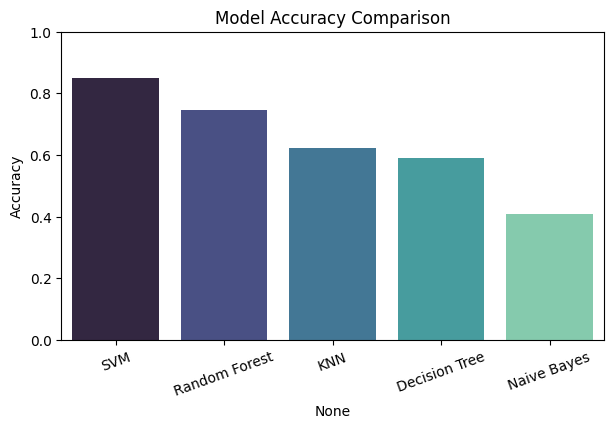

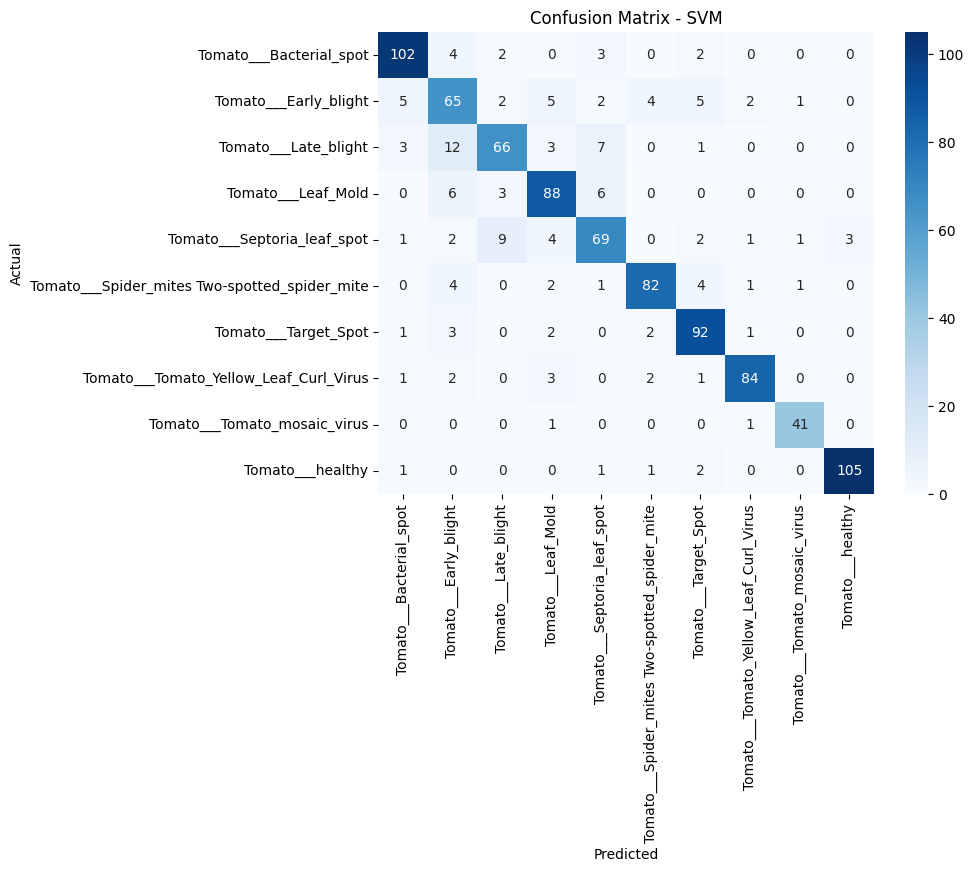


--- SVM ---


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.894737,0.902655,0.898678,113.000000
Tomato___Early_blight,0.663265,0.714286,0.687831,91.000000
Tomato___Late_blight,0.804878,0.717391,0.758621,92.000000
Tomato___Leaf_Mold,0.814815,0.854369,0.834123,103.000000
Tomato___Septoria_leaf_spot,0.775281,0.750000,0.762431,92.000000
Tomato___Spider_mites Two-spotted_spider_mite,0.901099,0.863158,0.881720,95.000000
Tomato___Target_Spot,0.844037,0.910891,0.876190,101.000000
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.933333,0.903226,0.918033,93.000000
Tomato___Tomato_mosaic_virus,0.931818,0.953488,0.942529,43.000000
Tomato___healthy,0.972222,0.954545,0.963303,110.000000



--- Decision Tree ---


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.690476,0.769912,0.728033,113.000000
Tomato___Early_blight,0.381818,0.461538,0.417910,91.000000
Tomato___Late_blight,0.404255,0.413043,0.408602,92.000000
Tomato___Leaf_Mold,0.532110,0.563107,0.547170,103.000000
Tomato___Septoria_leaf_spot,0.563218,0.532609,0.547486,92.000000
Tomato___Spider_mites Two-spotted_spider_mite,0.555556,0.526316,0.540541,95.000000
Tomato___Target_Spot,0.585859,0.574257,0.580000,101.000000
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.752941,0.688172,0.719101,93.000000
Tomato___Tomato_mosaic_virus,0.744186,0.744186,0.744186,43.000000
Tomato___healthy,0.800000,0.654545,0.720000,110.000000



--- Random Forest ---


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.826446,0.884956,0.854701,113.000000
Tomato___Early_blight,0.561905,0.648352,0.602041,91.000000
Tomato___Late_blight,0.698413,0.478261,0.567742,92.000000
Tomato___Leaf_Mold,0.724771,0.766990,0.745283,103.000000
Tomato___Septoria_leaf_spot,0.693182,0.663043,0.677778,92.000000
Tomato___Spider_mites Two-spotted_spider_mite,0.660870,0.800000,0.723810,95.000000
Tomato___Target_Spot,0.707547,0.742574,0.724638,101.000000
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.850000,0.731183,0.786127,93.000000
Tomato___Tomato_mosaic_virus,0.871795,0.790698,0.829268,43.000000
Tomato___healthy,0.925234,0.900000,0.912442,110.000000



--- KNN ---


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.803419,0.831858,0.817391,113.000000
Tomato___Early_blight,0.486486,0.395604,0.436364,91.000000
Tomato___Late_blight,0.569231,0.402174,0.471338,92.000000
Tomato___Leaf_Mold,0.590551,0.728155,0.652174,103.000000
Tomato___Septoria_leaf_spot,0.683333,0.445652,0.539474,92.000000
Tomato___Spider_mites Two-spotted_spider_mite,0.545455,0.631579,0.585366,95.000000
Tomato___Target_Spot,0.461538,0.653465,0.540984,101.000000
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.737500,0.634409,0.682081,93.000000
Tomato___Tomato_mosaic_virus,0.648148,0.813953,0.721649,43.000000
Tomato___healthy,0.757282,0.709091,0.732394,110.000000



--- Naive Bayes ---


,precision,recall,f1-score,support
Tomato___Bacterial_spot,0.494253,0.761062,0.599303,113.00000
Tomato___Early_blight,0.514286,0.197802,0.285714,91.00000
Tomato___Late_blight,0.500000,0.130435,0.206897,92.00000
Tomato___Leaf_Mold,0.611111,0.106796,0.181818,103.00000
Tomato___Septoria_leaf_spot,0.428571,0.065217,0.113208,92.00000
Tomato___Spider_mites Two-spotted_spider_mite,0.282723,0.568421,0.377622,95.00000
Tomato___Target_Spot,0.343590,0.663366,0.452703,101.00000
Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.567010,0.591398,0.578947,93.00000
Tomato___Tomato_mosaic_virus,0.246154,0.744186,0.369942,43.00000
Tomato___healthy,0.727273,0.363636,0.484848,110.00000


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# =========================================================
# 1️⃣ Prepare Data
# =========================================================
# k=processed_images_train[:4000]
# processed_images_test=processed_images_test+processed_images_train[4000:]
# processed_images_train=k
X_train = np.array([f for f, _ in processed_images_train], dtype=np.float32)
y_train = np.array([l for _, l in processed_images_train])
X_test  = np.array([f for f, _ in processed_images_test], dtype=np.float32)
y_test  = np.array([l for _, l in processed_images_test])

# Replace NaN/Inf values (safe normalization)
X_train = np.nan_to_num(X_train)
X_test  = np.nan_to_num(X_test)

# Feature scaling for distance-based models (SVM, KNN, NB)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

results = {}

# =========================================================
# 2️⃣ Train Models
# =========================================================

# --- SVM (RBF kernel) ---
svm_model = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced',random_state=42)
svm_model.fit(X_train_s, y_train)
y_pred_svm = svm_model.predict(X_test_s)
results['SVM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Report': classification_report(y_test, y_pred_svm, output_dict=True),
    'y_pred': y_pred_svm
}

# --- Decision Tree ---
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
results['Decision Tree'] = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Report': classification_report(y_test, y_pred_dt, output_dict=True),
    'y_pred': y_pred_dt
}

# --- Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Report': classification_report(y_test, y_pred_rf, output_dict=True),
    'y_pred': y_pred_rf
}

# --- KNN ---
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='minkowski',
    p=2
)
knn_model.fit(X_train_s, y_train)
y_pred_knn = knn_model.predict(X_test_s)
results['KNN'] = {
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Report': classification_report(y_test, y_pred_knn, output_dict=True),
    'y_pred': y_pred_knn
}

# --- Naive Bayes ---
nb_model = GaussianNB()
nb_model.fit(X_train_s, y_train)
y_pred_nb = nb_model.predict(X_test_s)
results['Naive Bayes'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'Report': classification_report(y_test, y_pred_nb, output_dict=True),
    'y_pred': y_pred_nb
}

# =========================================================
# 3️⃣ Summarize & Visualize
# =========================================================

# Accuracy Table
acc_data = {m: results[m]['Accuracy'] for m in results}
acc_df = pd.DataFrame.from_dict(acc_data, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False)

print("\n📊 Model Performance Summary:")
display(acc_df)

# Bar Chart
plt.figure(figsize=(7,4))
sns.barplot(x=acc_df.index, y=acc_df['Accuracy'], palette="mako")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.show()

# =========================================================
# 4️⃣ Confusion Matrix for Best Model
# =========================================================
best_model_name = acc_df.index[0]
best_y_pred = results[best_model_name]['y_pred']

cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# =========================================================
# 5️⃣ Detailed Classification Reports
# =========================================================
for model, metrics in results.items():
    print(f"\n--- {model} ---")
    rep_df = pd.DataFrame(metrics['Report']).transpose()
    display(rep_df)



# Implementing MLP

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# -----------------------------------------
# Assumes you already built these earlier:
# X_train, X_test, y_train, y_test
# X_train_s, X_test_s (StandardScaler outputs)
# results = {}
# -----------------------------------------

# 1) Encode string labels -> integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
num_classes = len(le.classes_)

# 2) Build a simple MLP for tabular feature vectors
model = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 3) Train
history = model.fit(
    X_train_s, y_train_enc,
    epochs=40, batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 4) Evaluate
test_loss, test_acc = model.evaluate(X_test_s, y_test_enc, verbose=0)
print(f"\nNeuralNet Test Accuracy: {test_acc:.4f}")

# 5) Predictions + report (optional)
y_pred_logits = model.predict(X_test_s, verbose=0)
y_pred = np.argmax(y_pred_logits, axis=1)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# 6) Log into your existing results dict
results["NeuralNet"] = float(test_acc)



Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2563 - loss: 2.1180 - val_accuracy: 0.4920 - val_loss: 1.4105
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4596 - loss: 1.5049 - val_accuracy: 0.5885 - val_loss: 1.1979
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5391 - loss: 1.2989 - val_accuracy: 0.6434 - val_loss: 1.0473
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5912 - loss: 1.1613 - val_accuracy: 0.6836 - val_loss: 0.9481
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6312 - loss: 1.0449 - val_accuracy: 0.7279 - val_loss: 0.8376
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6494 - loss: 1.0082 - val_accuracy: 0.7399 - val_loss: 0.7945
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6834 - loss: 0.9442 - val_accuracy: 0.7560 - val_loss: 0.7483
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.8471 - val_accuracy: 0.7668 - val_loss:

# Implementing CNN

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [7]:
CSV_PATH   = '../data/csv/data.csv'
train_path = '../data/pkl/processed_images_train_CNN.pkl'
test_path = '../data/pkl/processed_images_test_CNN.pkl'
TOKEN_PATH = '../../../../Tokens/github_token.txt'   
SEED       = 42
IMG_SIZE   = 256   # smaller = faster (128/160/192 are good options)
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
CHANNELS = 3
BATCH      = 32
EPOCHS     = 10    # EarlyStopping will stop earlier if needed
AUGMENT    = True  # toggle augmentation
USE_CLASS_WEIGHTS = True  # set False if classes are balanced

tf.random.set_seed(SEED)
np.random.seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

## Finding Total Classes

In [8]:
CATEGORIES = pd.read_csv(CSV_PATH)['class'].unique()
print(CATEGORIES)
NUM_CATEGORIES=len(CATEGORIES)
NUM_CATEGORIES

['Tomato___Bacterial_spot' 'Tomato___Late_blight' 'Tomato___Leaf_Mold'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Early_blight'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Septoria_leaf_spot'
 'Tomato___healthy' 'Tomato___Target_Spot' 'Tomato___Tomato_mosaic_virus']


10

class
Tomato___Bacterial_spot                          1000
Tomato___Late_blight                             1000
Tomato___Spider_mites Two-spotted_spider_mite    1000
Tomato___Early_blight                            1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Target_Spot                             1000
Tomato___healthy                                 1000
Tomato___Leaf_Mold                                952
Tomato___Tomato_mosaic_virus                      373
Name: count, dtype: int64


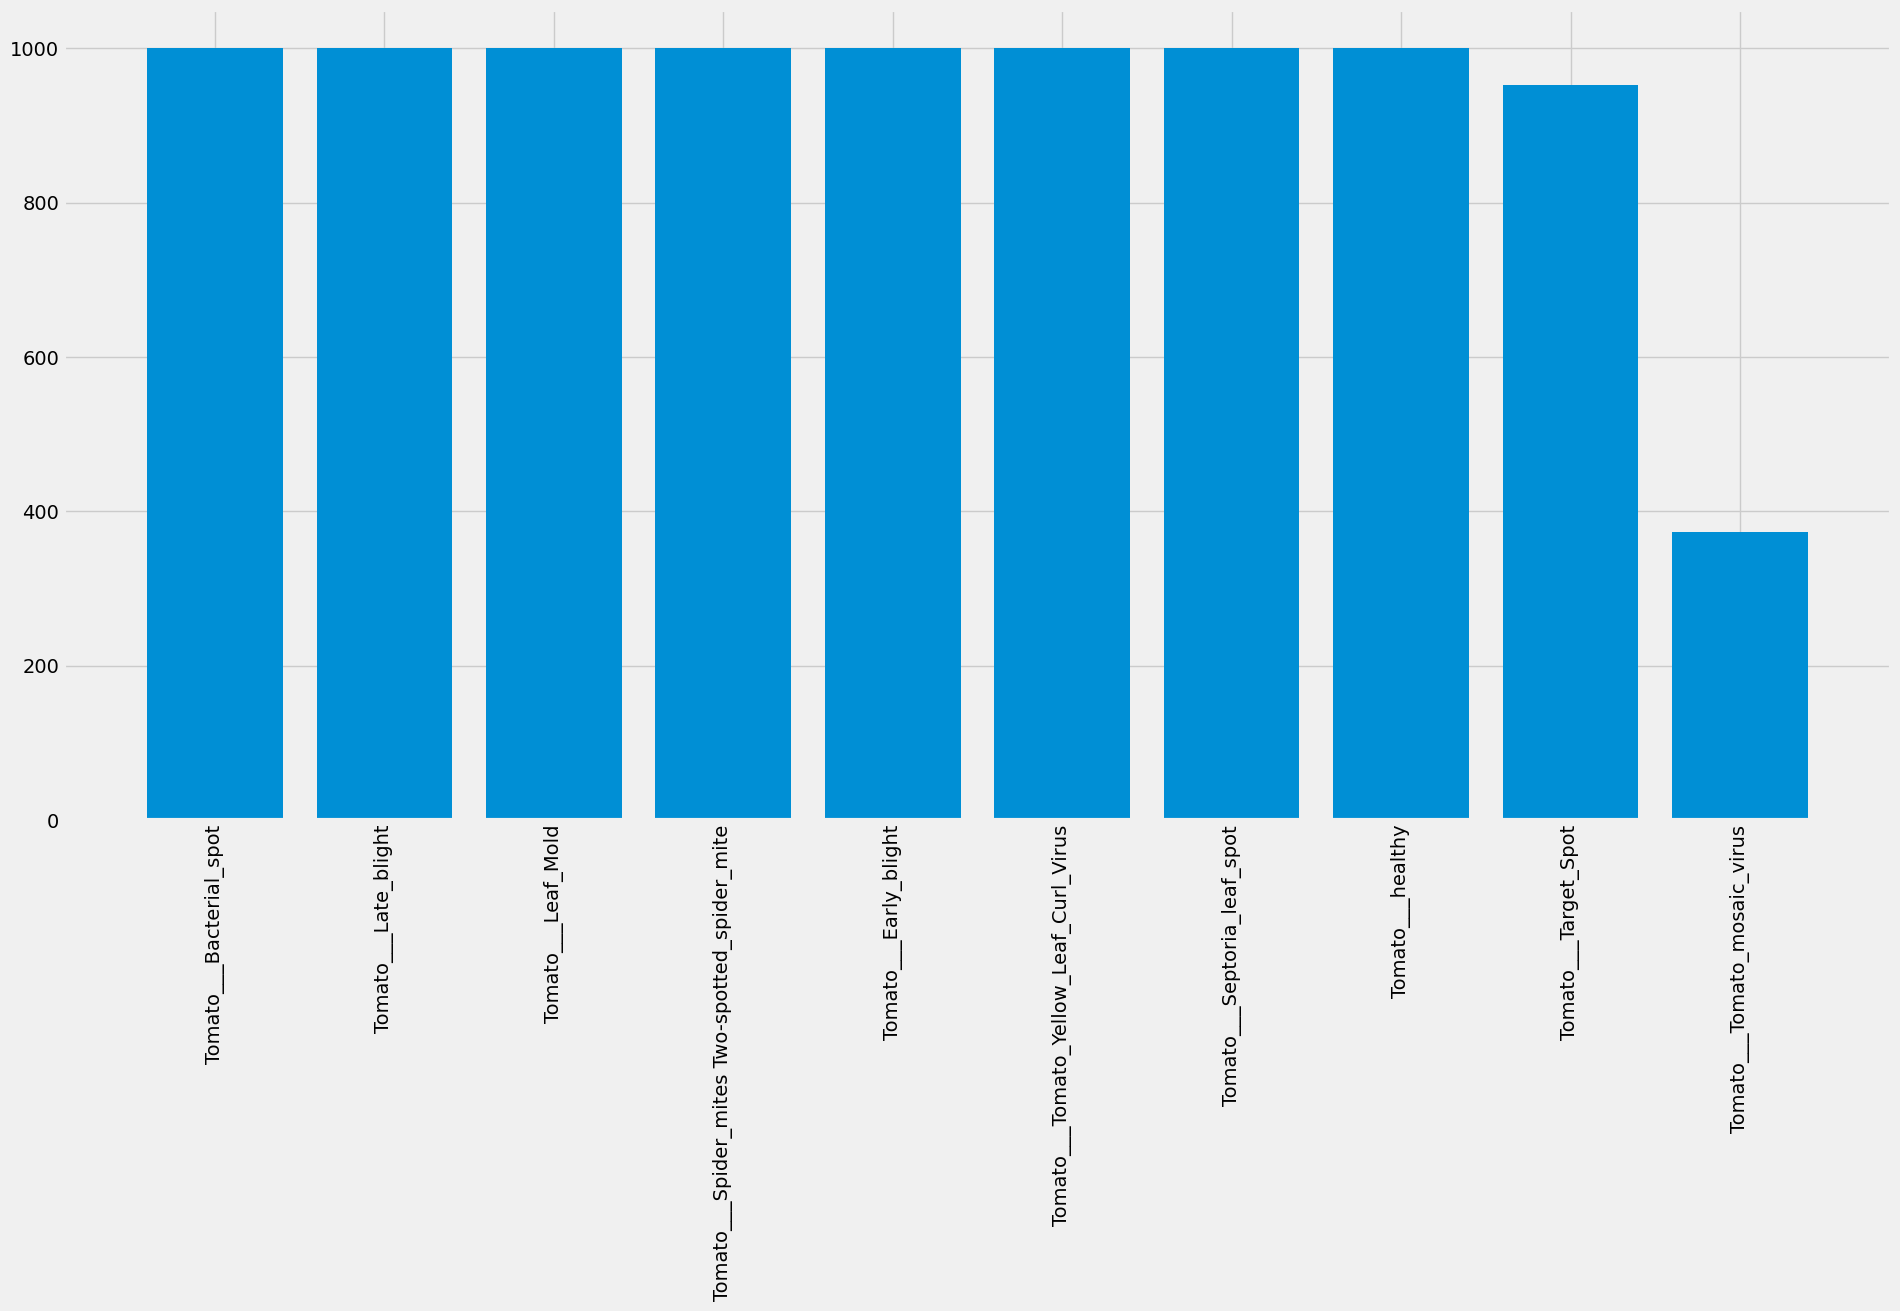

In [9]:
df=pd.read_csv(CSV_PATH)
gd=df['class'].value_counts()
print(gd.head(10))

plt.figure(figsize=(21,10))
plt.bar(CATEGORIES, gd)
plt.xticks(CATEGORIES, rotation='vertical')
plt.show()

In [10]:
token=get_token()

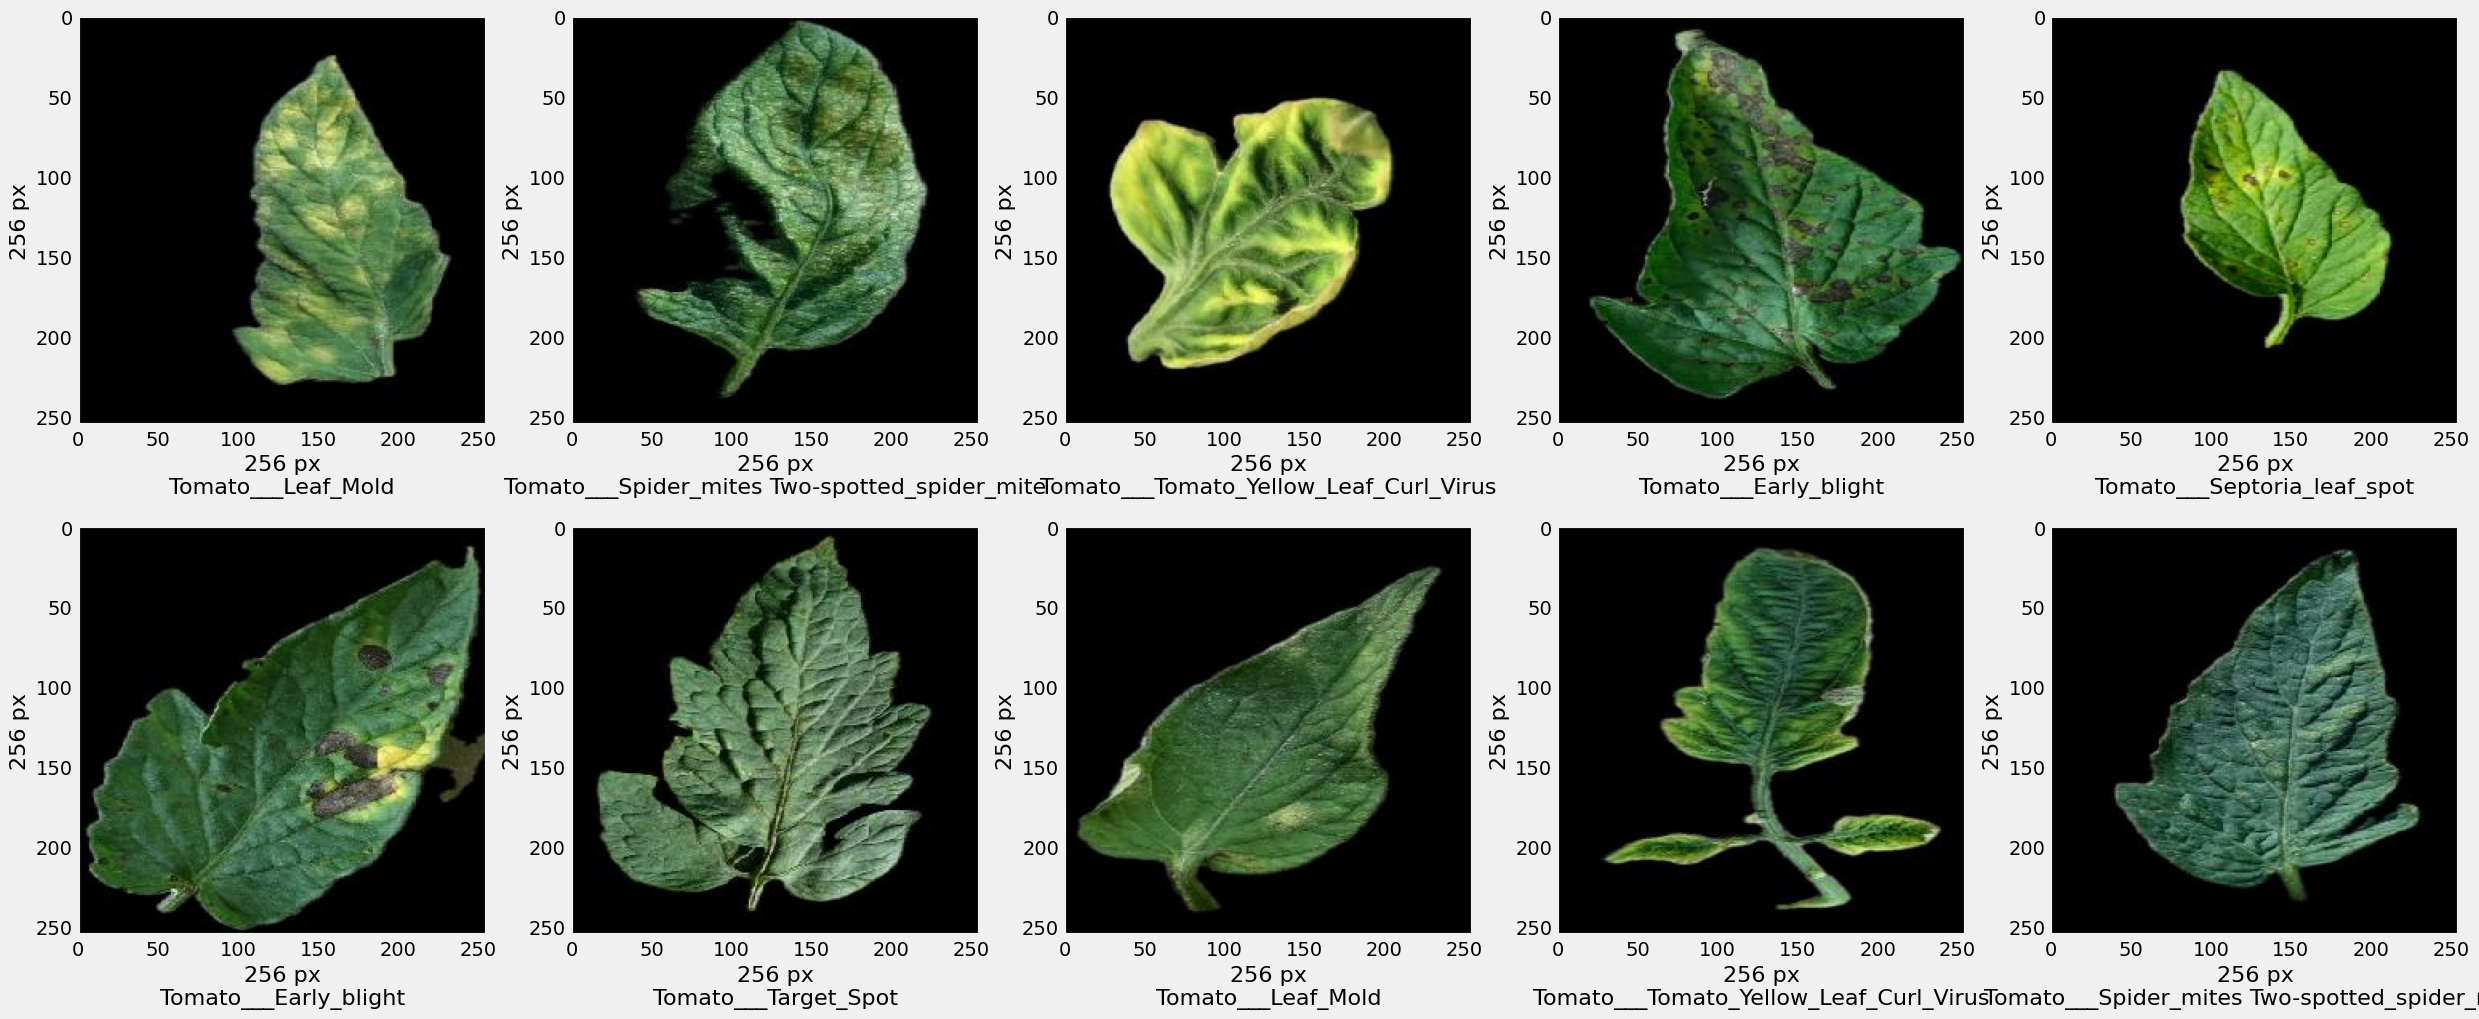

In [11]:
import random
from matplotlib.image import imread

n=10 #no of images

test = pd.read_csv(CSV_PATH)
imgs_url_label = test.values
plt.figure(figsize=(25, 25))
shown = 0

while shown < n:
    choice=random.choice(imgs_url_label)
    random_img_URL = choice[0]
    random_img_label=choice[-1]
    headers = {"Authorization": f"token {token}"}
    response = requests.get(random_img_URL, headers=headers, stream=True, timeout=10)
    response.raise_for_status()
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    img_array = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    if img is not None:
        shown += 1
        plt.subplot(5, 5, shown)
        plt.imshow(img)
        plt.grid(False)
        plt.xlabel(f"{img.shape[1]} px\n{random_img_label}", fontsize=16)
        plt.ylabel(f"{img.shape[0]} px", fontsize=16)
    else:
        print(f"Failed to decode image: {url}")

    

plt.tight_layout()
plt.show()


In [12]:
print(gd[-1])

373


C:\Users\user\AppData\Local\Temp\ipykernel_13328\851504560.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(gd[-1])


In [13]:
classes=dict(zip(CATEGORIES,range(10)))
print(classes)

classes_2=dict(zip(range(10),CATEGORIES))
print(classes_2)

{'Tomato___Bacterial_spot': 0, 'Tomato___Late_blight': 1, 'Tomato___Leaf_Mold': 2, 'Tomato___Spider_mites Two-spotted_spider_mite': 3, 'Tomato___Early_blight': 4, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5, 'Tomato___Septoria_leaf_spot': 6, 'Tomato___healthy': 7, 'Tomato___Target_Spot': 8, 'Tomato___Tomato_mosaic_virus': 9}
{0: 'Tomato___Bacterial_spot', 1: 'Tomato___Late_blight', 2: 'Tomato___Leaf_Mold', 3: 'Tomato___Spider_mites Two-spotted_spider_mite', 4: 'Tomato___Early_blight', 5: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 6: 'Tomato___Septoria_leaf_spot', 7: 'Tomato___healthy', 8: 'Tomato___Target_Spot', 9: 'Tomato___Tomato_mosaic_virus'}


In [14]:
import os
import cv2
import numpy as np
from PIL import Image
import random
import pickle

image_data = []
image_labels = []
df=pd.read_csv(CSV_PATH)
imgs_url_label = df.values

MAX = 5000
loaded=0
skipped=0
for i in range(MAX):
    try:
        print(f"\rLoading image {i+1}/{MAX}", end="",flush=True)
        choice=imgs_url_label[i]
        random_img_URL = choice[0]
        random_img_label=choice[-1]
        headers = {"Authorization": f"token {token}"}
        response = requests.get(random_img_URL, headers=headers, stream=True, timeout=10)
        response.raise_for_status()
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        if img is not None:
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image,(IMG_HEIGHT,IMG_WIDTH))
            image_data.append(np.array(image))
            image_labels.append(classes[random_img_label])
            loaded+=1
        else:
            skipped+=1
    except:
        skipped+=1

print(f"\rFinished. Images loaded: {loaded} | Images Skipped: {skipped} | Total Images: {MAX}")

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(f"Dataset shape: {image_data.shape}, Labels shape: {image_labels.shape}")

with open('../data/raw/image_data.pkl', 'wb') as file:
    pickle.dump(image_data, file)
    
with open('../data/raw/image_labels.pkl', 'wb') as file:
    pickle.dump(image_labels, file)
    

Finished. Images loaded: 4995 | Images Skipped: 5 | Total Images: 5000
Dataset shape: (4995, 256, 256, 3), Labels shape: (4995,)


In [15]:
import pickle
with open('../data/raw/image_data.pkl', 'rb') as file:
    image_data=pickle.load(file)
    
with open('../data/raw/image_labels.pkl', 'rb') as file:
    image_labels=pickle.load(file)

In [16]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [17]:
NUM_CATEGORIES = len(np.unique(image_labels))
print("No of categories for training:",NUM_CATEGORIES)
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.15, random_state=42, shuffle=True)
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.15/(0.7+0.15), random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255
X_test=X_test/255


print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)
print("y_test.shape", y_test.shape)


No of categories for training: 10
X_train.shape (3495, 256, 256, 3)
X_valid.shape (750, 256, 256, 3)
X_test.shape (750, 256, 256, 3)
y_train.shape (3495,)
y_valid.shape (750,)
y_test.shape (750,)


In [18]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

#no at posn 2 represents the no of neurons in the output layer

y_train shape: (3495, 10)
y_val shape: (750, 10)


In [19]:
channels = 3  # or 1 if grayscale
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    # added block (minimal change)
    keras.layers.Conv2D(256, (3,3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    # swap Flatten -> GAP (keeps params under control on 128x128)
    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
])


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

EPOCHS=30
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=EPOCHS * 100,  # roughly adjust based on dataset size
    decay_rate=0.9,            # multiply LR by 0.9 every decay_steps
    staircase=True
)

opt = Adam(learning_rate=lr_schedule)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [21]:
print("Model output layer neurons:", model.output_shape[-1])
print("y_train shape:", y_train.shape)

Model output layer neurons: 10
y_train shape: (3495, 10)


In [22]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=EPOCHS, validation_data=(X_val, y_val))

model.save('cnn_model.h5')

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.3763 - loss: 2.0841 - val_accuracy: 0.1347 - val_loss: 3.4869
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.5265 - loss: 1.4933 - val_accuracy: 0.1533 - val_loss: 6.1328
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.5971 - loss: 1.2136 - val_accuracy: 0.1693 - val_loss: 7.0877
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.6761 - loss: 0.9839 - val_accuracy: 0.2493 - val_loss: 3.0493
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7176 - loss: 0.8308 - val_accuracy: 0.2680 - val_loss: 3.3197
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7233 - loss: 0.8098 - val_accuracy: 0.4480 - val_loss: 2.0582
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7499 - loss: 0.7364 - val_accuracy: 0.6013 - val_loss: 1.4965
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.7745 - loss: 0.6419 - val_accu

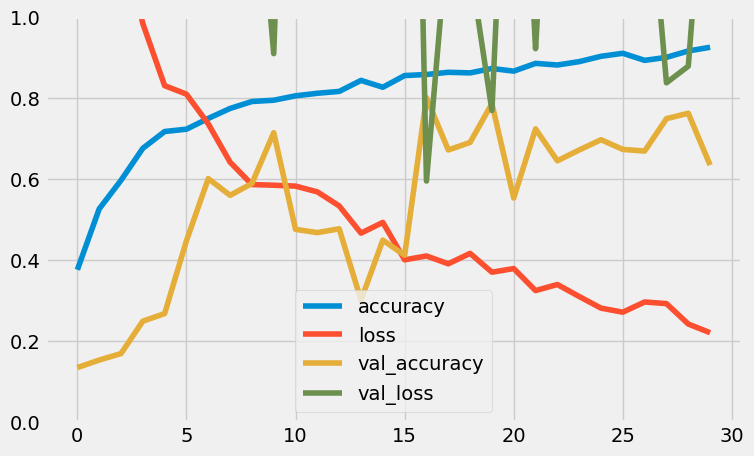

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [24]:
from tensorflow.keras.models import load_model
model = load_model('cnn_model.h5')

In [25]:
# Predict
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # replaces deprecated predict_classes

# Accuracy
print("Test samples used:", len(X_test))
lim=len(X_test)
print("Test Data Accuracy:", accuracy_score(y_test, y_pred) * 100)

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step
Test samples used: 750
Test Data Accuracy: 61.33333333333333
